**IMPORT STATEMENTS**

In [ ]:
import pandas as pd
import gc
import numpy as np

**DATA LOADING**

In [ ]:
# from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# ## Change working directory
import os
os.chdir('/content/drive/MyDrive/AI/AI_Project')
print(os.getcwd())

In [ ]:
# #Unzip
# # Only run when needed
# dir_data = 'glove.twitter.27B.zip'

# if os.path.exists(dir_data)==True:
#   !unzip $dir_data
# else:
#   print("File not found")

**DATA PREPROCESSING**


In [ ]:
Dataset = pd.read_csv('./TweetsCOV19.tsv', sep='\t', error_bad_lines=False)
print(len(Dataset.index))
# Dataset = Dataset.iloc[:,:]
# print(len(Dataset.index))
Dataset.columns = ["tweet_id","username","timestamp","#followers","#retweets","#friends","#favorites","entities","sentiment","mentions","hashtags","urls"]
Dataset = Dataset.iloc[:,1:]
Dataset.head()

b'Skipping line 3609902: expected 12 fields, saw 13\n'


8077792


,username,timestamp,#followers,#retweets,#friends,#favorites,entities,sentiment,mentions,hashtags,urls
0,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...
1,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:
2,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;
3,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;
4,6ff6c6532fe0c399dcedd1dad6249c28,Mon Sep 30 22:39:03 +0000 2019,284,935,0,0,cnn:CNN:-0.9113024985533761;,3 -2,null;,null;,null;


In [ ]:
# Import stop words and convert it into a set(no duplicates) for later use
# Stop words taken from nltk corpus 
stopWordsFile = open("./stop_words.txt")
stopWords = stopWordsFile.readlines()
stopWordsList=[]
for k in stopWords:
    stopWordsList+=k.split()
stopWordsSet = set(stopWordsList)

In [ ]:
# Import keywords and convert it into a set(no duplicates) for later use
covidKeywordsFile = open("./covid_keywords.txt")
covidKeywords = covidKeywordsFile.readlines()
covidKeywordsList=[]
for k in covidKeywords:
    covidKeywordsList+=k.split()
covidKeywordsSet = set(covidKeywordsList)

In [ ]:
# Process current timestamp field to datetime format

monthStringToInt={"Jan":'1',"Feb":'2',"Mar":'3',"Apr":'4',"May":'5',"Jun":'6',"Sep":'9',"Oct":'10',"Nov":'11',"Dec":'12'}
def createDate(timestamp):
    lst = timestamp.split(" ")
    dt=lst[2]+"-"+monthStringToInt[lst[1]]+"-"+lst[-1]+" "+lst[3]
    return dt

Dataset["date"]=Dataset["timestamp"].apply(lambda x: createDate(x))
Dataset["date"]=pd.to_datetime(Dataset["date"],format="%d-%m-%Y %H:%M:%S")

In [ ]:
# Split dataset into train and validation splits

trainRatio = 0.7 # Validation ratio = 1 - trainRatio
valRatio = 0.2
testRatio = 0.1
trainSize=int(Dataset.shape[0]*trainRatio)
valSize = int(Dataset.shape[0]*valRatio)
testSize = int(Dataset.shape[0]*testRatio)
Dataset=Dataset.sort_values("date").reset_index(drop=True)
trainDataset = Dataset.iloc[:trainSize,:]
validationDataset = Dataset.iloc[trainSize:(trainSize + testSize),:]
testDataset = Dataset.iloc[(trainSize + testSize):,:]

print(Dataset.shape[0])
print(trainDataset.shape[0])
print(validationDataset.shape[0])
print(testDataset.shape[0])
print(trainDataset.shape[0] + validationDataset.shape[0] + testDataset.shape[0])

8077792
5654454
807779
1615559
8077792


In [ ]:
Dataset.head()

,username,timestamp,#followers,#retweets,#friends,#favorites,entities,sentiment,mentions,hashtags,urls,date
0,c3169076a5b18d050b695b946910ea83,Mon Sep 30 22:00:00 +0000 2019,18864,10,0,0,xi an:Xi%27an:-1.1902657303624196;chengdu:Chen...,1 -1,null;,5G China,null;,2019-09-30 22:00:00
1,3ca14b66d568d29c8e7b6793d3e94e02,Mon Sep 30 22:00:00 +0000 2019,8164,8192,4,11,null;,1 -1,null;,"SundayShoutOut, Covers Couchjams",https://www.youtube.com/watch?v=nOZtgCFfH0o&fe...,2019-09-30 22:00:00
2,c57d4fb895c5f4a33d2a2b24709f93b5,Mon Sep 30 22:00:01 +0000 2019,764191,132,19,180,foodie:Foodie:-2.096663959988218;,1 -1,null;,HalloweenTime?,null;,2019-09-30 22:00:01
3,627f7d4ef584ba33a676a4ebcb861cdb,Mon Sep 30 22:00:02 +0000 2019,321189,26833,32,43,mainland china:Mainland_China:-1.6252666161640...,1 -1,null;,HongKong,https://www.catholicnewsagency.com/news/amid-h...,2019-09-30 22:00:02
4,32a54e5f6d8a67de1bffd2e689594dc8,Mon Sep 30 22:00:03 +0000 2019,171,138,33,117,my family:My_Family:-2.6353832182503094;roll t...,4 -1,null;,null;,null;,2019-09-30 22:00:03


**HELPER FUNCTIONS**

In [ ]:
# Helper Functions
def createDict(unique_val, start):
  count=start
  dic ={}
  for k in unique_val:
      dic[k]=count
      count+=1
  return dic

In [ ]:
def preprocessData(Dataset, covidKeywords, stopWords, isTrainData, usernameDict, standardizeDict):
  #===========================================================================================================================
  # Preprocessing username
  if isTrainData:
    # If is train dataset, create the dictionary for later use
    # Filtering out people that have <tweets_threshold number of tweets
    tweetsThreshold = 10 
    userCounts = Dataset["username"].value_counts()
    userCounts = userCounts[userCounts>=tweetsThreshold] 

    # Creating dictionary of username mapping for later use in validation set
    usernameDict["username"] = createDict(userCounts.index, 1) 
    Dataset["username"] = Dataset["username"].map(usernameDict["username"])
    Dataset["username"] = Dataset["username"].fillna(0)

  else: 
    # If is not train dataset(i.e. is Validation or test set), use previously made username dictionary to map usernames
    # Mapping username column to username dictionary previously created when preprocessing trainDataset
    Dataset["username"] = Dataset["username"].map(usernameDict)
    Dataset["username"] = Dataset["username"].fillna(0)

  #===========================================================================================================================
  # Preprocessing null fields
  Dataset["followers_null_ind"] = Dataset["#followers"].isnull().astype(int)
  Dataset["friends_null_ind"] = Dataset["#friends"].isnull().astype(int)

  Dataset["entity_null"] = (Dataset["entities"]=="null;").astype(int)
  Dataset["hashtags_null"] = (Dataset["hashtags"]=="null;").astype(int)
  Dataset["urls_null"] = (Dataset["urls"]=="null;").astype(int)
  Dataset["mentions_null"] = (Dataset["mentions"]=="null;").astype(int)

  #===========================================================================================================================
  # Preprocessing hashtags
  def keyword_hashtags(x,key_covid):
    if x=="null;":
        return 0
    else:
      # print(x)
      s = str(x).split(" ")
      ff=[]
      for z in s:
          ff.append(z.lower())
      count=0
      for zz in ff:
          if zz in key_covid:
              count+=1
      return count
        
  Dataset["keyword_hashtags"] = Dataset["hashtags"].apply(lambda x: keyword_hashtags(x, covidKeywords))

  #===========================================================================================================================
  # Preprocessing entities
  def keyword_entities(x,key_covid):
    if x=="null;":
        return 0
    else:
      # print(x)
      s = str(x).split(";")
      ff=[]
      for z in s[:-1]:
          temp = z.split(":")
          ff.append(temp[0].lower())
          ff.append(temp[1].lower())
      count=0
      for zz in ff:
          if zz in key_covid:
              count+=1
      return count

  Dataset["keyword_entities"] = Dataset["entities"].apply(lambda x: keyword_entities(x, covidKeywords))

  #===========================================================================================================================
  # Preprocessing sentiments
  def one_hot_sentiment(x):
      spl = x.split(" ")
      d =[0]*10
      d[int(spl[0])-1]=1
      d[int(spl[-1])]=1
      return d

  Dataset["sentiment_encoded"] = Dataset["sentiment"].apply(lambda x: one_hot_sentiment(x))

  #===========================================================================================================================
  # Preprocessing counts
  def count(x,sep):
    if x!="null;" and str(x)!="nan":
        cc = x.split(sep)
        return len(cc)
    else:
        return 0
    
  def unique_hashtags(x):
      if x=="null;" or str(x)=="nan":
          return 0
      else:
          x=x.split(" ")
          return np.unique(x).size/len(x)
      
  def count_words(x):
      if x=="null;" or str(x)=="nan":
          return 0
      else:
          return len(x)

  Dataset["no_entities"] = Dataset["entities"].apply(lambda x: count(x,";"))
  Dataset["no_urls"] = Dataset["urls"].apply(lambda x: count(x,":-:"))
  Dataset["no_hashtags"] = Dataset["hashtags"].apply(lambda x: count(x," "))
  Dataset["no_mentions"] = Dataset["mentions"].apply(lambda x: count(x," "))
  Dataset["unique_hashtags"] = Dataset["hashtags"].apply(lambda x: unique_hashtags(x))
  Dataset["hashtags_char"] = Dataset["hashtags"].apply(lambda x: count_words(x))

  #===========================================================================================================================
  # Preprocessing timestamp
  def one_hot_week(x,dict_):
    len_=len(dict_)
    z=[0]*len_
    z[dict_[x]]=1
    return z
    
  def conv_dtime(v):
        v = v.split(":")
        return (float(v[0])*3600+float(v[1])*60+float(v[2]))/3600

  Dataset["week"] = Dataset["timestamp"].apply(lambda x: x.split(" ")[0])
  #Dataset["month"] = Dataset["timestamp"].apply(lambda x: x.split(" ")[1])
  Dataset["day"] = Dataset["timestamp"].apply(lambda x: x.split(" ")[2])
  Dataset["time"] = Dataset["timestamp"].apply(lambda x: x.split(" ")[3])
  Dataset["year"] = Dataset["timestamp"].apply(lambda x: x.split(" ")[5])

  if isTrainData:
        usernameDict["week"] = createDict(Dataset["week"].unique(), 0)

  Dataset["week"] = Dataset["week"].apply(lambda x: one_hot_week(x,usernameDict["week"]))
  #Dataset["month"] = Dataset["month"].map(month_dict)
  Dataset["time"] = Dataset["time"].apply(lambda x: conv_dtime(x))
  Dataset["day"] = Dataset["day"].astype(int)
  Dataset["year"] = Dataset["year"].map({"2019":0,"2020":1})

  #===========================================================================================================================
  # Preprocessing ratio
  Dataset["follow/friends"]=Dataset["#followers"].astype(float)/(Dataset["#friends"].astype(float)+1)
  Dataset["friends/favorites"]=Dataset["#friends"].astype(float)/(Dataset["#favorites"].astype(float)+1)
  Dataset["favorites/follow"]=Dataset["#favorites"].astype(float)/(Dataset["#followers"].astype(float)+1)

  #===========================================================================================================================
  # log
  Dataset["#followers"]=np.log(Dataset["#followers"].astype(int)+1)
  Dataset["#friends"]=np.log(Dataset["#friends"].astype(int)+1)
  Dataset["#favorites"]=np.log(Dataset["#favorites"].astype(int)+1)
  Dataset["no_entities"]=np.log(Dataset["no_entities"].astype(int)+1)
  Dataset["no_urls"]=np.log(Dataset["no_urls"].astype(int)+1)
  Dataset["no_mentions"]=np.log(Dataset["no_mentions"].astype(int)+1)
  Dataset["no_hashtags"]=np.log(Dataset.no_hashtags+1)

  Dataset["day"]=np.log(Dataset["day"].astype(int)+1)
  Dataset["time"]=np.log(Dataset["time"].astype(int)+1)
  Dataset["follow/friends"]=np.log(Dataset["follow/friends"]+1)
  Dataset["friends/favorites"]=np.log(Dataset["friends/favorites"]+1)
  Dataset["favorites/follow"]=np.log(Dataset["favorites/follow"]+1)
  Dataset["unique_hashtags"]=np.log(Dataset["follow/friends"]+1)
  Dataset["hashtags_char"]=np.log(Dataset["hashtags_char"]+1)
  Dataset["keyword_entities"]=np.log(Dataset["keyword_entities"]+1)
  Dataset["keyword_hashtags"]=np.log(Dataset["keyword_hashtags"]+1)

  #===========================================================================================================================
  # Standardizing values = finding how many standard deviation away from mean
  featuresToStandardize=['#favorites', '#followers', '#friends', 'day', 'no_entities', 'no_hashtags', 
                        'no_mentions', 'no_urls','time',"follow/friends","friends/favorites","favorites/follow",
                      "unique_hashtags","hashtags_char","keyword_entities", "keyword_hashtags"]
  if isTrainData: 
    # If is train dataset, create the dictionary to save mean and standard deviation for later use in preprocessing validation set
    standardizeDict = {}
    for feature in featuresToStandardize:
      meanValue = Dataset[feature].mean()
      standardDeviationValue = Dataset[feature].std()
      Dataset[feature] = (Dataset[feature]-meanValue)/standardDeviationValue 
      standardizeDict[feature] = {"meanValue": meanValue, "standardDeviationValue": standardDeviationValue}
  else: 
    # If is not train dataset(i.e. is Validation or test set), use previously made mean and standard deviation dictionary from train dataset to standardize
    for feature in featuresToStandardize:
      Dataset[feature] = (Dataset[feature]-standardizeDict[feature]["meanValue"])/standardizeDict[feature]["standardDeviationValue"]

  #===========================================================================================================================
  # Returning relevant information
  if isTrainData: 
    # If is train dataset, return the preprocessed dataset, usernameDict and standardizeDict for use in validation and test dataset
    return Dataset, usernameDict, standardizeDict
  else: 
    # If is not train dataset(i.e. is Validation or test set), just return the preprocessed dataset
    return Dataset

In [ ]:
preprocessedTrainDataset, usernameDict, standardizeDict = preprocessData(trainDataset, covidKeywordsList, stopWords, isTrainData=True, usernameDict={}, standardizeDict={})
preprocessedValidationDataset = preprocessData(validationDataset, covidKeywordsList, stopWords, isTrainData=False, usernameDict=usernameDict, standardizeDict=standardizeDict)
# preprocessedTestDataset = preprocessData(testDataset, covidKeywordsList, stopWords, isTrainData=False, usernameDict=usernameDict, standardizeDict=standardizeDict)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

In [ ]:
del trainDataset
del validationDataset
del testDataset
del Dataset
pd.set_option('display.max_columns', None)

In [ ]:
preprocessedTrainDataset.head()

,username,timestamp,#followers,#retweets,#friends,#favorites,entities,sentiment,mentions,hashtags,urls,date,followers_null_ind,friends_null_ind,entity_null,hashtags_null,urls_null,mentions_null,keyword_hashtags,keyword_entities,sentiment_encoded,no_entities,no_urls,no_hashtags,no_mentions,unique_hashtags,hashtags_char,week,day,time,year,follow/friends,friends/favorites,favorites/follow
0,16300.0,Mon Sep 30 22:00:00 +0000 2019,0.818471,10,-0.732559,-0.723696,xi an:Xi%27an:-1.1902657303624196;chengdu:Chen...,1 -1,null;,5G China,null;,2019-09-30 22:00:00,0,0,0,0,1,1,2.573184,3.304439,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1.900868,-0.560255,1.398987,-0.672201,1.162985,0.921775,"[1, 0, 0, 0, 0, 0, 0]",1.034221,0.940574,0,1.510821,-0.697779,-0.144761
1,0.0,Mon Sep 30 22:00:00 +0000 2019,0.545189,8192,0.186529,0.417183,null;,1 -1,null;,"SundayShoutOut, Covers Couchjams",https://www.youtube.com/watch?v=nOZtgCFfH0o&fe...,2019-09-30 22:00:00,0,0,1,0,0,1,-0.305948,-0.293299,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",-1.400206,1.756713,1.912730,-0.672201,0.575461,1.827000,"[1, 0, 0, 0, 0, 0, 0]",1.034221,0.940574,0,0.531237,0.257695,-0.138421
2,20112.0,Mon Sep 30 22:00:01 +0000 2019,2.026365,132,0.978188,1.663057,foodie:Foodie:-2.096663959988218;,1 -1,null;,HalloweenTime?,null;,2019-09-30 22:00:01,0,0,0,0,1,1,-0.305948,-0.293299,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0.250331,-0.560255,0.674908,-0.672201,1.307892,1.277673,"[1, 0, 0, 0, 0, 0, 0]",1.034221,0.940574,0,1.793437,-0.366247,-0.143652
3,3041.0,Mon Sep 30 22:00:02 +0000 2019,1.743511,26833,1.264161,1.013715,mainland china:Mainland_China:-1.6252666161640...,1 -1,null;,HongKong,https://www.catholicnewsagency.com/news/amid-h...,2019-09-30 22:00:02,0,0,0,0,0,1,-0.305948,-0.293299,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0.682540,1.756713,0.674908,-0.672201,1.018302,0.921775,"[1, 0, 0, 0, 0, 0, 0]",1.034221,0.940574,0,1.245870,1.117447,-0.144131
4,0.0,Mon Sep 30 22:00:03 +0000 2019,-0.714462,138,1.281209,1.466638,my family:My_Family:-2.6353832182503094;roll t...,4 -1,null;,null;,null;,2019-09-30 22:00:03,0,0,0,1,1,1,-0.305948,-0.293299,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]",0.682540,-0.560255,-0.562914,-0.672201,-1.951833,-0.609056,"[1, 0, 0, 0, 0, 0, 0]",1.034221,0.940574,0,-1.711914,0.121234,2.298945


In [ ]:
preprocessedValidationDataset.head()

,username,timestamp,#followers,#retweets,#friends,#favorites,entities,sentiment,mentions,hashtags,urls,date,followers_null_ind,friends_null_ind,entity_null,hashtags_null,urls_null,mentions_null,keyword_hashtags,keyword_entities,sentiment_encoded,no_entities,no_urls,no_hashtags,no_mentions,unique_hashtags,hashtags_char,week,day,time,year,follow/friends,friends/favorites,favorites/follow
5654454,0,Wed Apr 01 11:36:25 +0000 2020,1.755259,1263,1.615002,1.576805,harborview medical center:Harborview_Medical_C...,3 -1,null;,null;,https://edition.cnn.com/2020/03/30/us/brooklyn...,2020-04-01 11:36:25,0,0,0,1,0,1,-0.305948,-0.293299,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1]",0.682540,1.756713,-0.562914,-0.672201,0.883938,-0.609056,"[0, 0, 1, 0, 0, 0, 0]",-3.098082,0.149209,1,1.014314,0.419741,-0.142654
5654455,0,Wed Apr 01 11:36:26 +0000 2020,-0.754800,156,-0.732559,-0.723696,gochujang:Gochujang:-0.832688496046354;chilli ...,1 -1,RubeusEques,null;,null;,2020-04-01 11:36:26,0,0,0,1,1,0,-0.305948,-0.293299,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1.017787,-0.560255,-0.562914,0.447349,-0.188348,-0.609056,"[0, 0, 1, 0, 0, 0, 0]",-3.098082,0.149209,1,-0.419671,-0.697779,-0.144761
5654456,0,Wed Apr 01 11:36:26 +0000 2020,-1.224826,417,-0.732559,-0.723696,null;,1 -1,yaneerbaryam,Masks4All,https://twitter.com/TourOfTheFuture/status/124...,2020-04-01 11:36:26,0,0,1,0,0,0,2.573184,-0.293299,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",-1.400206,1.756713,0.674908,0.447349,-0.816384,0.995181,"[0, 0, 1, 0, 0, 0, 0]",-3.098082,0.149209,1,-0.996418,-0.697779,-0.144761
5654457,0,Wed Apr 01 11:36:27 +0000 2020,0.379226,5179,0.378675,0.908648,null;,2 -1,null;,StayAtHome,null;,2020-04-01 11:36:27,0,0,1,0,1,1,2.573184,-0.293299,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1]",-1.400206,-0.560255,0.674908,-0.672201,0.331959,1.061585,"[0, 0, 1, 0, 0, 0, 0]",-3.098082,0.149209,1,0.193154,-0.172272,-0.112265
5654458,0,Wed Apr 01 11:36:27 +0000 2020,-1.642826,81,-0.732559,-0.723696,germany:Germany:-1.8234082238173337;,2 -2,Ava_lou82 gemkg84 piersmorgan,null;,null;,2020-04-01 11:36:27,0,0,0,1,1,0,-0.305948,-0.293299,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",0.250331,-0.560255,-0.562914,1.566900,-1.569669,-0.609056,"[0, 0, 1, 0, 0, 0, 0]",-3.098082,0.149209,1,-1.509328,-0.697779,-0.144761


In [ ]:
# preprocessedTestDataset.head()

**Word Embeddings**

In [ ]:
def combine_entity(x):
    a = split_word(x,0)+" "+bigrams(x,0)
    a = " ".join(a.split())
    return a

def hashtag(k):
    if k=="null;":
        return ""
    else:
        k=str(k)
        orig=k.lower().split()
        # print(k)
        k= re.sub(r'[^a-zA-Z]'," ",k)
        # print(k)
        k=" ".join(k.split())
        # print(k)
        k=" ".join([a for a in re.split('([A-Z][a-z]+)', k) if a])
        # print(k)
        k=k.lower().split()+orig
        # print(k)
        ff=[]
        check_set=set()
        for zz in k:
            if zz not in check_set:
                ff.append(zz)
                check_set.add(zz)
        return " ".join(ff)

def process_urlPath(x,pos,stop_set):
    if x=="null;":
        return ""
    else:
        x = str(x)
        spl=x.split(":-:")[:-1]
        res=[]
        for k in spl:
            uert = split_url(k,"d")
            rt = re.sub("[^A-Za-z]"," ",uert[pos])
            rt = rt.split()
            ur_spl=[]
            for ul in rt:
                if ul not in stop_set:
                    ur_spl.append(ul)
            res.append(" ".join(ur_spl))
        return " ".join(res)

def split_url(line, part):
    # this is copy of split_url function from the URLNetrepository: https://github.com/Antimalweb/URLNet/blob/master/utils.py
    if line.startswith("http://"):
        line=line[7:]
    if line.startswith("https://"):
        line=line[8:]
    if line.startswith("ftp://"):
        line=line[6:]
    if line.startswith("www."):
        line = line[4:]
    slash_pos = line.find('/')
    if slash_pos > 0 and slash_pos < len(line)-1: # line = "fsdfsdf/sdfsdfsd"
        primarydomain = line[:slash_pos]
        path_argument = line[slash_pos+1:]
        path_argument_tokens = path_argument.split('/')
        pathtoken = "/".join(path_argument_tokens[:-1])
        last_pathtoken = path_argument_tokens[-1]
        if len(path_argument_tokens) > 2 and last_pathtoken == '':
            pathtoken = "/".join(path_argument_tokens[:-2])
            last_pathtoken = path_argument_tokens[-2]
        question_pos = last_pathtoken.find('?')
        if question_pos != -1:
            argument = last_pathtoken[question_pos+1:]
            pathtoken = pathtoken + "/" + last_pathtoken[:question_pos]     
        else:
            argument = ""
            pathtoken = pathtoken + "/" + last_pathtoken          
        last_slash_pos = pathtoken.rfind('/')
        sub_dir = pathtoken[:last_slash_pos]
        filename = pathtoken[last_slash_pos+1:]
        file_last_dot_pos = filename.rfind('.')
        if file_last_dot_pos != -1:
            file_extension = filename[file_last_dot_pos+1:]
            filename = filename[:file_last_dot_pos]
        else:
            file_extension = "" 
    elif slash_pos == 0:    # line = "/fsdfsdfsdfsdfsd"
        primarydomain = line[1:]
        pathtoken = ""
        argument = ""
        sub_dir = ""
        filename = ""
        file_extension = ""
    elif slash_pos == len(line)-1:   # line = "fsdfsdfsdfsdfsd/"
        primarydomain = line[:-1]
        pathtoken = ""
        argument = ""
        sub_dir = ""     
        filename = ""
        file_extension = ""
    else:      # line = "fsdfsdfsdfsdfsd"
        primarydomain = line
        pathtoken = ""
        argument = ""
        sub_dir = "" 
        filename = ""
        file_extension = ""
    if part == 'pd':
        return primarydomain
    elif part == 'path':
        return pathtoken
    elif part == 'argument': 
        return argument 
    elif part == 'sub_dir': 
        return sub_dir 
    elif part == 'filename': 
        return filename 
    elif part == 'fe': 
        return file_extension
    elif part == 'others': 
        if len(argument) > 0: 
            return pathtoken + '?' +  argument 
        else: 
            return pathtoken 
    else:
        return primarydomain, pathtoken, argument, sub_dir, filename, file_extension

def split_word(x,pos):
    if x == "null;":
        return ""
    else:
        x = str(x)
        s = x.split(";")[:-1]
        ff=[]
        check_set=set()
        for z in s:
            d = z.split(":")
            ent=d[pos]
            ent2 = re.sub("%\d+"," ",d[pos+1])
            ent2 = re.sub("_","",ent2)
            ent2 = ent2.lower().split()
            #ent = [ent.lower()]+ent2
            ent = [ent.lower()]
            for zz in ent:
                if zz not in check_set:
                    ff.append(zz)
                    check_set.add(zz)
        rt= " ".join(ff)
        return rt

def create_bigram(h):
    dr=[]
    start=h[0]
    for k in h[1:]:
        dr.append(start+k)
        start=k
    return dr

def bigrams(x,pos):
    if x == "null;":
        return ""
    else:
        x = str(x)
        s = x.split(";")[:-1]
        ff=[]
        check_set=set()
        for z in s:
            d = z.split(":")
            ent2 = re.sub("%\d+"," ",d[pos+1])
            ent2 = re.sub("_"," ",ent2)
            ent2 = ent2.lower().split()
            if len(ent2)>1:
                ff+=create_bigram(ent2)
        if len(ff)==0:
            return ""
        else:
            return " ".join(ff)


In [ ]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import io
import gc
import re
import string
# from utils import *
import tensorflow as tf

def load_vectors(fname,count_words):
        fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
        # n, d = map(int, fin.readline().split())
        data = {}
        data_list=[]
        for line in fin:
            tokens = line.rstrip().split(' ')
            tk = tokens[0]
            if tk in count_words:
                vec=list(map(float, tokens[1:]))
                data[tk] = vec
                data_list.append(vec)
        return data,data_list
    
    
def glove_load_vectors(fname,count_words):
        data={}
        fastvec = open(fname)
        counter=1
        data_list=[]
        while counter>0:
            try:
                f=fastvec.__next__()
                tokens = f.rstrip().split(' ')
                tk=tokens[0]
                if tk in count_words:
                    vec = list(map(float, tokens[1:]))
                    data[tk] = vec
                    data_list.append(vec)
                counter+=1
            except:
                print("total tokens",counter)
                counter=0
                pass
        return data,data_list

def create_embeddings(train_data,embedding_path,wordvec_name,stop_set,word_dim):

    entity1 =  train_data["entities"].apply(lambda x: combine_entity(x))
    mention_dt =  train_data["hashtags"].apply(lambda x: hashtag(x))
    url_dt1 =  train_data["urls"].apply(lambda x: process_urlPath(x,0,stop_set))
    url_dt2 =  train_data["urls"].apply(lambda x: process_urlPath(x,1,stop_set))
    mention_splt = train_data["mentions"].apply(lambda x: hashtag(x))
    
    dt_concat =pd.concat([entity1,mention_dt,url_dt1,url_dt2,mention_splt],axis=0)
    
    print("create entity tokenizer")

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',
        lower=True,
        split=" ",
        char_level=False,
        oov_token=None)

    #tokenizer.fit_on_texts(pd.concat([entity1,mention_dt,url_dt,mention_splt],axis=0))
    tokenizer.fit_on_texts(dt_concat)
    
    count_thres = 15
    count_words = {w:c for w,c in tokenizer.word_counts.items() if c >= count_thres}

    word_counts= len(count_words)+1#one for oov and one for less count words

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=word_counts,
        filters='',
        lower=True,
        split=" ",
        char_level=False,
        oov_token=None)

    #tokenizer.fit_on_texts(pd.concat([entity1,mention_dt,url_dt,mention_splt],axis=0))
    tokenizer.fit_on_texts(dt_concat)
    
    print("load embedding vectors")
    if wordvec_name.split(".")[0]=="glove":
        fastvec,fastvec_list = glove_load_vectors(embedding_path,count_words)
    else:
        fastvec,fastvec_list = load_vectors(embedding_path,count_words)

    cand=np.array(fastvec_list,dtype='float32')
    mu=np.mean(cand, axis=0)
    Sigma=np.cov(cand.T)
    norm=np.random.multivariate_normal(mu, Sigma, 1)
    norm = list(np.reshape(norm, word_dim))

    word_counts = len(count_words)+1
    word_vectors = np.zeros((word_counts,word_dim))
    id_w = tokenizer.index_word

    for k in range(1,word_vectors.shape[0]):
        ky = id_w[k]
        if ky in fastvec:
            word_vectors[k,:]=fastvec[ky]
        else:
            word_vectors[k,:]= norm
    
    return tokenizer,word_counts,word_vectors

embedding_path = "./glove.twitter.27B.200d.txt"
wordvec_name = "./glove.twitter.27B.200d.txt"
wordvec_dim = 200

# tokenizer,vocab_len,word_vec = create_embeddings(Dataset,embedding_path,wordvec_name,stopWordsSet,wordvec_dim)

**MODEL**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import io
import gc
import re
import string
from urllib.parse import urlparse

## see if we need the use cnn option, if not we can remove it and make it default

#user embedding layers
def attention_user(embed_entity,embed_user,cnn_option):
    user_embedding_word= tf.keras.layers.Dense(100,activation='relu')(embed_user)
    user_embedding_word= tf.keras.layers.Flatten()(user_embedding_word)
    if cnn_option==1:
        embed_entity = tf.keras.layers.Convolution1D(filters=150, kernel_size=3,  padding='same', activation='relu', strides=1)(embed_entity)
    else:
        embed_entity=tf.keras.layers.LSTM(150,return_sequences=True)(embed_entity)
    attention_a=tf.keras.layers.Dot((2, 1))([embed_entity,tf.keras.layers.Dense(150,activation='tanh')(user_embedding_word)])
    attention_weight = tf.keras.layers.Activation('softmax')(attention_a)
    news_rep=tf.keras.layers.Dot((1, 1))([embed_entity, attention_weight])
    return news_rep


#custom loss metrics to track performance
def msle_function(actual,prediction):
    prediction = tf.keras.backend.exp(prediction)-1
    pred = tf.keras.backend.round(prediction)
    pred = tf.keras.backend.log(prediction+1)
    error = (actual-prediction)**2
    mean_error = tf.keras.backend.mean(error)
    return mean_error


def model(feature_dicts,word_vec,vec_d,vocab_len,cnn_option):
    user_length = len(feature_dicts["username"])+1
    #user embedding length
    embedding_len = 64
    tf.compat.v1.disable_eager_execution()
    #create input heads
    user_inp = tf.keras.layers.Input((1,))                 ##### might need to edit these numbers according to our choice of input
    sentiment_inp = tf.keras.layers.Input((10,))
    week_inp=tf.keras.layers.Input((7,))
    all_feats_inp = tf.keras.layers.Input((23,))
    entity_inp1 = tf.keras.layers.Input((10,))
    hashtag_inp = tf.keras.layers.Input((5,))
    urlPath_inp1 = tf.keras.layers.Input((3,))    #find out if this is host and path and change name accordingly
    urlPath_inp2 = tf.keras.layers.Input((15,))
    mentionsplt_inp = tf.keras.layers.Input((5,))

    #create embedding for users
    user_embed = tf.keras.layers.Embedding(input_dim=user_length, output_dim=embedding_len,embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=123),input_length=1)
    entity_embed = tf.keras.layers.Embedding(input_dim=vocab_len, output_dim=vec_d,weights=[word_vec],trainable=True)


    #query embeddings
    embed_user =user_embed(user_inp)
    embedding_user = tf.keras.layers.Lambda(lambda y: tf.keras.backend.squeeze(y, 1))(embed_user)

    embed_entity =entity_embed(entity_inp1)
    embed_entity= tf.keras.layers.Dropout(0.25)(embed_entity)
    entity_features_conv1 = attention_user(embed_entity,embed_user,cnn_option)


    embedding_hashtag =entity_embed(hashtag_inp)
    embedding_hashtag= tf.keras.layers.Dropout(0.25)(embedding_hashtag)
    hashtag_features_conv = attention_user(embedding_hashtag,embed_user,cnn_option)

    embedding_urlPath1 =entity_embed(urlPath_inp1)
    embedding_urlPath1= tf.keras.layers.Dropout(0.25)(embedding_urlPath1)
    urlPath_features_conv1 = attention_user(embedding_urlPath1,embed_user,cnn_option)

    embedding_urlPath2 =entity_embed(urlPath_inp2)
    embedding_urlPath2= tf.keras.layers.Dropout(0.25)(embedding_urlPath2)
    urlPath_features_conv2 = attention_user(embedding_urlPath2,embed_user,cnn_option)

    embedding_mentionsplt =entity_embed(mentionsplt_inp)
    embedding_mentionsplt= tf.keras.layers.Dropout(0.25)(embedding_mentionsplt)
    mentionsplt_features_conv = attention_user(embedding_mentionsplt,embed_user,cnn_option)


    inp_feats = tf.keras.layers.concatenate([embedding_user, sentiment_inp,week_inp,all_feats_inp,entity_features_conv1,hashtag_features_conv,urlPath_features_conv1,urlPath_features_conv2,mentionsplt_features_conv], 1)

    fc1 = tf.keras.layers.Dense(500, activation=tf.keras.activations.relu,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(inp_feats)
    drop1 = tf.keras.layers.Dropout(rate=0.15,seed=456)(fc1)
    fc2 = tf.keras.layers.Dense(150, activation=tf.keras.activations.relu,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=456))(drop1)
    drop2 = tf.keras.layers.Dropout(rate=0.15,seed=34)(fc2)
    out = tf.keras.layers.Dense(1,activation=tf.keras.activations.relu,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=789))(drop2)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model_cp = tf.keras.models.Model(inputs=[user_inp,sentiment_inp,week_inp,all_feats_inp,entity_inp1,hashtag_inp,urlPath_inp1,urlPath_inp2,mentionsplt_inp],outputs=[out])
    # model_cp.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(),optimizer=optimizer,metrics=[msle_function,'accuracy'])## edited mean squared error to meansquared log loss
    model_cp.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(),optimizer=optimizer,metrics=["mean_squared_logarithmic_error", "accuracy"])
    return model_cp

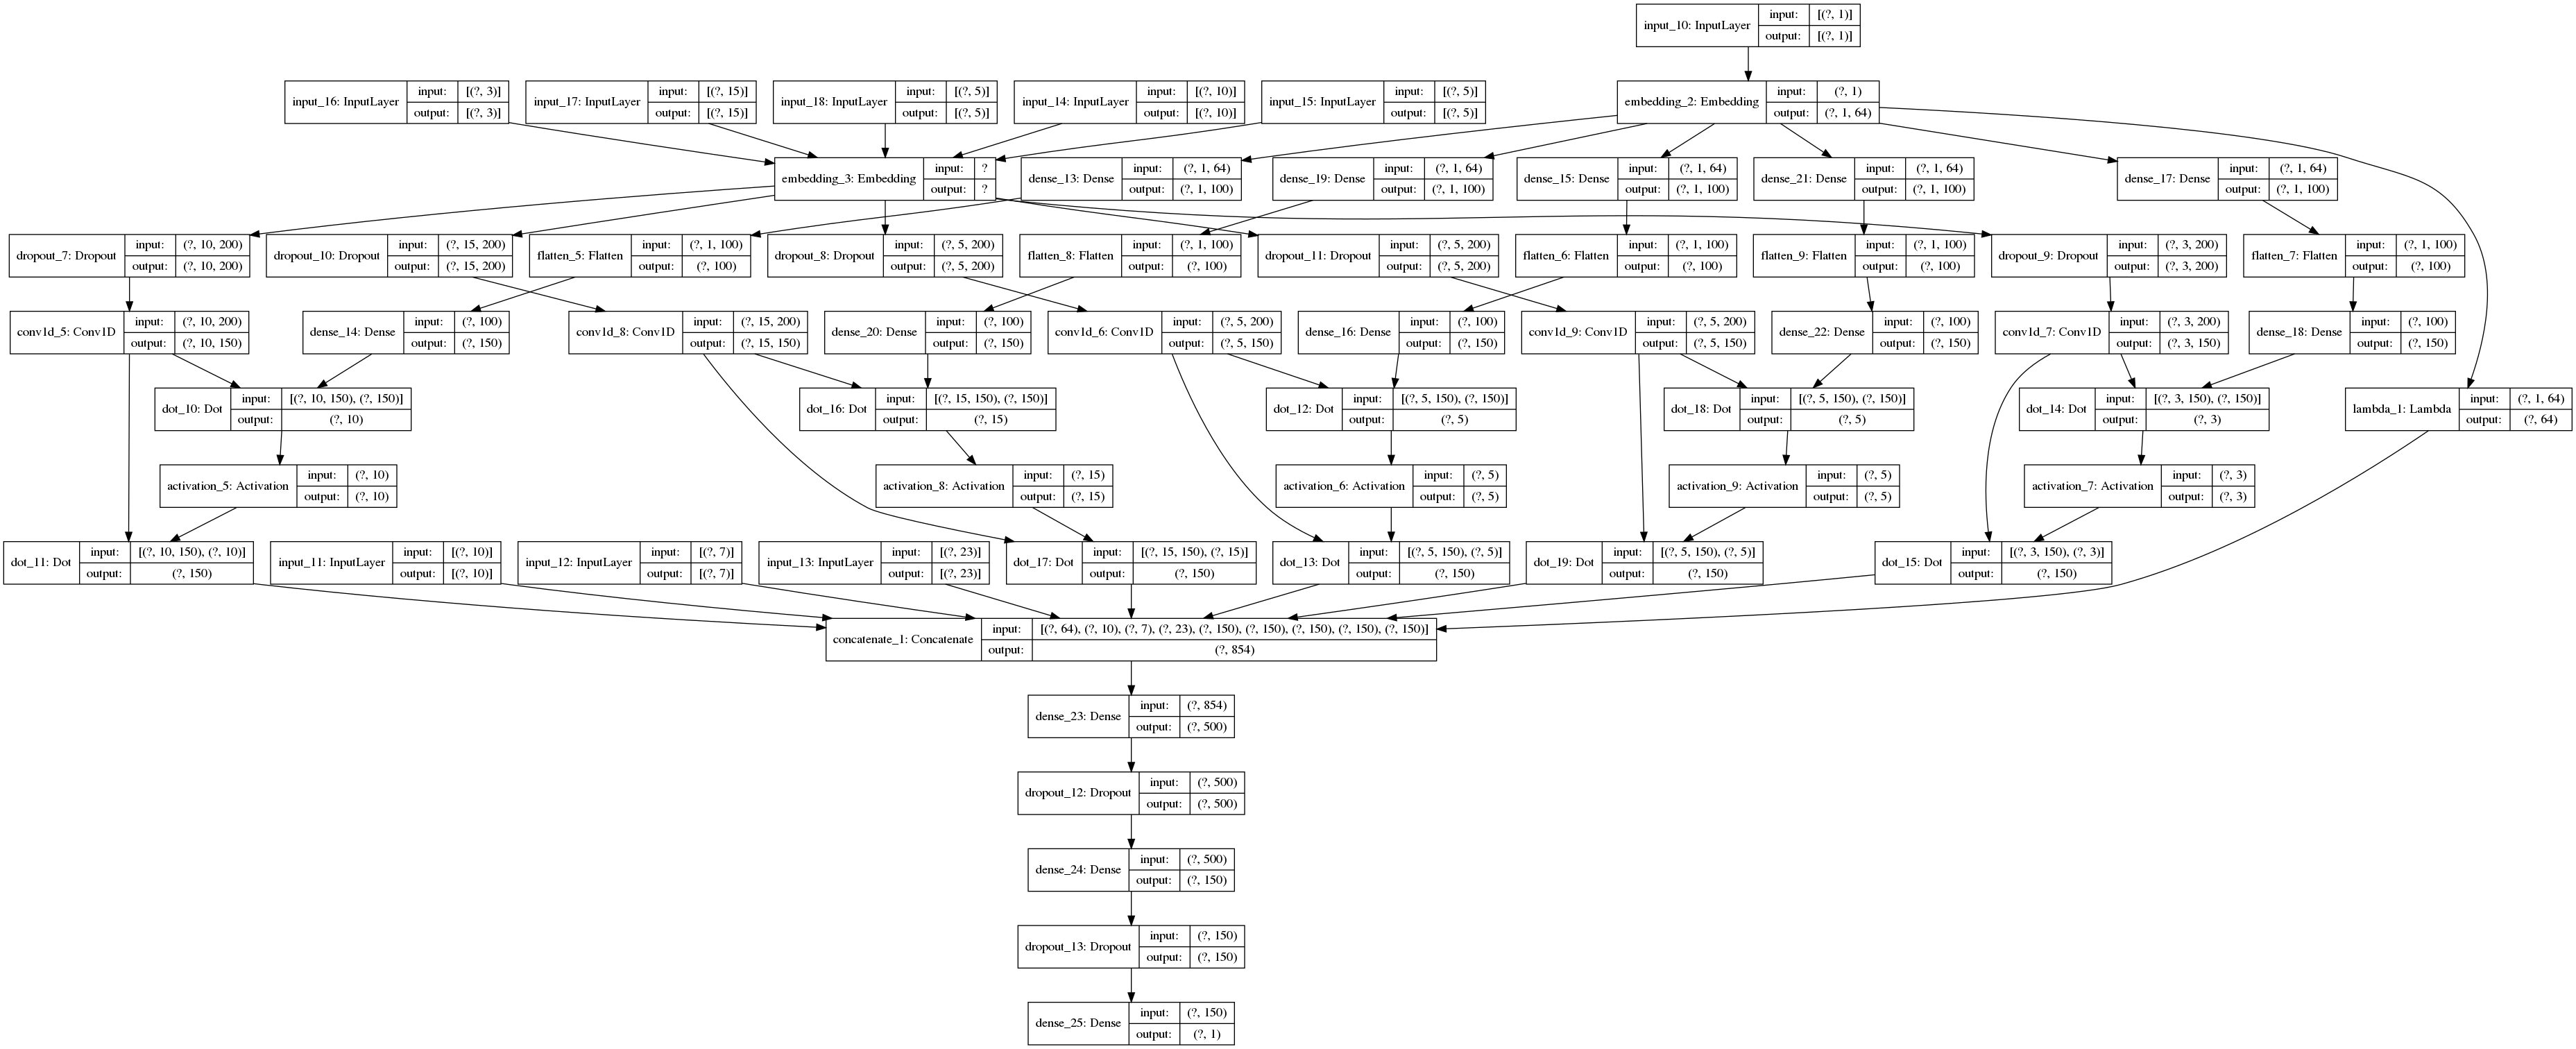

In [ ]:
model_cp = model(usernameDict,word_vec,wordvec_dim,vocab_len,cnn_option=1)
tf.keras.utils.plot_model(model_cp, to_file='projmodel_test.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import numpy as np
import pandas as pd

class batch_generator(Sequence):
    def __init__(self, dataset,tokenizer,stop_set,batch_size,shuffle=True,is_train=True):
        self.dataset=dataset
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.shuffle = shuffle
        self.is_train = is_train
        self.stop_set=stop_set
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.dataset.shape[0] / float(self.batch_size)))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.dataset.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        data_chunck = self.dataset.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        username_ = data_chunck[["username"]].values
        sentiment_encode = np.array(data_chunck["sentiment_encoded"].tolist())
        week_encode = np.array(data_chunck["week"].tolist())
        other_f = ['#favorites', '#followers', '#friends', 'day',
      'no_entities', 'no_hashtags', 'no_mentions', 'no_urls','time',"year","follow/friends","friends/favorites","favorites/follow","unique_hashtags","hashtags_char","entity_null","hashtags_null","urls_null","mentions_null","keyword_entities","keyword_hashtags",
                  'followers_null_ind', 'friends_null_ind']
        all_fea= data_chunck[other_f].values
        
        entity1 =  data_chunck["entities"].apply(lambda x: combine_entity(x))
        entity_sequences1 = self.tokenizer.texts_to_sequences(entity1)
        entity_pad1 = tf.keras.preprocessing.sequence.pad_sequences(
            entity_sequences1, maxlen=10, dtype='int32', padding='pre', truncating='post')
        
        hashtag_process =  data_chunck["hashtags"].apply(lambda x: hashtag(x))
        valid_hashtag = self.tokenizer.texts_to_sequences(hashtag_process)
        hashtag_valid = tf.keras.preprocessing.sequence.pad_sequences(
            valid_hashtag, maxlen=5, dtype='int32', padding='pre', truncating='post')
        
        url_dt1 =  data_chunck["urls"].apply(lambda x: process_urlPath(x,0,self.stop_set))
        urlPath_sequences1 = self.tokenizer.texts_to_sequences(url_dt1)
        urlPath_valid1 = tf.keras.preprocessing.sequence.pad_sequences(
            urlPath_sequences1, maxlen=3, dtype='int32', padding='pre', truncating='post')

        url_dt2 =  data_chunck["urls"].apply(lambda x: process_urlPath(x,1,self.stop_set))
        urlPath_sequences2 = self.tokenizer.texts_to_sequences(url_dt2)
        urlPath_valid2 = tf.keras.preprocessing.sequence.pad_sequences(
            urlPath_sequences2, maxlen=15, dtype='int32', padding='pre', truncating='post')

        mention_splt =  data_chunck["mentions"].apply(lambda x: hashtag(x))
        mention_validsplt = self.tokenizer.texts_to_sequences(mention_splt)
        mention_validsplt = tf.keras.preprocessing.sequence.pad_sequences(
            mention_validsplt, maxlen=5, dtype='int32', padding='pre', truncating='post')
        
        batch_x = [username_,sentiment_encode,week_encode,all_fea,entity_pad1,hashtag_valid,urlPath_valid1,urlPath_valid2,mention_validsplt]                
        if self.is_train:
            batch_y = data_chunck["#retweets"]
            return batch_x,batch_y
        else:
            return batch_x

In [ ]:
#create tokenizer
tokenizer,vocab_len,word_vec = create_embeddings(preprocessedTrainDataset,embedding_path,wordvec_name,stopWordsSet,wordvec_dim)
#built model
model_cp = model(usernameDict,word_vec,wordvec_dim,vocab_len,cnn_option=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  verbose=1,
                                                  patience=5,
                                                  mode='min',
                                                  restore_best_weights=True)

checkpoint_path= './Saved_Models'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_loss',
                                                  save_best_only=True,
                                                  save_weights_only=True,mode='min',
                                                  verbose=1)


create entity tokenizer
load embedding vectors
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# set batch sizes
batch_train = batch_generator(preprocessedTrainDataset,tokenizer,stopWordsSet,batch_size=128,shuffle=True,is_train=True)
batch_valid = batch_generator(preprocessedValidationDataset,tokenizer,stopWordsSet,batch_size=128,shuffle=False,is_train=True)
# batch_test = batch_generator(preprocessedTestDataset,tokenizer,stopWordsSet,batch_size=128,shuffle=False,is_train=False)

In [ ]:
# Full dataset WITHOUT tweet_id
history = model_cp.fit(batch_train, epochs=30, verbose=1,validation_data = batch_valid,callbacks =[early_stopping,cp_callback])

Epoch 1/30
 6310/44176 [===>..........................] - ETA: 9:04 - loss: 2.4149 - mean_squared_logarithmic_error: 2.4149 - accuracy: 0.0052
Epoch 00001: val_loss improved from inf to 2.41478, saving model to ./Saved_Models
44176/44176 [==============================] - 1052s 24ms/step - loss: 1.4225 - mean_squared_logarithmic_error: 1.4225 - accuracy: 0.0066 - val_loss: 2.4148 - val_mean_squared_logarithmic_error: 2.4148 - val_accuracy: 0.0052
Epoch 2/30
 6309/44176 [===>..........................] - ETA: 9:05 - loss: 2.2132 - mean_squared_logarithmic_error: 2.2132 - accuracy: 0.0052
Epoch 00002: val_loss improved from 2.41478 to 2.21306, saving model to ./Saved_Models
44176/44176 [==============================] - 1041s 24ms/step - loss: 1.0081 - mean_squared_logarithmic_error: 1.0081 - accuracy: 0.0078 - val_loss: 2.2131 - val_mean_squared_logarithmic_error: 2.2131 - val_accuracy: 0.0052
Epoch 3/30
 6308/44176 [===>..........................] - ETA: 9:08 - loss: 2.1641 - mean_squa

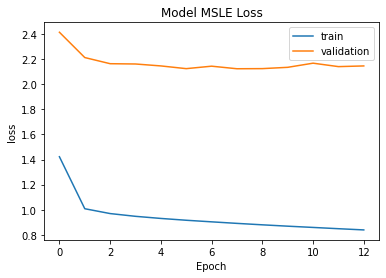

In [ ]:
## Plot for Full dataset WITHOUT tweet_id
## Plot train and validation accuracy for each epoch
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0, 1]) ## Range of y-axis values
plt.legend(loc='upper right')
plt.title('Model MSLE Loss')
plt.show()

Training

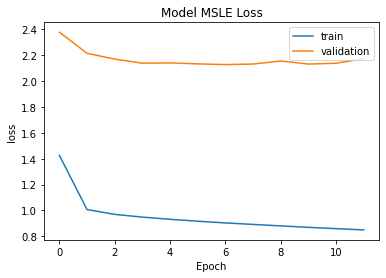

In [ ]:
## Plot for Full dataset WITH tweet_id
## Plot train and validation accuracy for each epoch
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0, 1]) ## Range of y-axis values
plt.legend(loc='upper right')
plt.title('Model MSLE Loss')
plt.show()

In [ ]:
## First Half of dataset WITH tweet_id
history = model_cp.fit(batch_train, epochs=30, verbose=1,validation_data = batch_valid,callbacks =[early_stopping,cp_callback])

Epoch 1/30
 3155/22088 [===>..........................] - ETA: 4:52 - loss: 2.2172 - mean_squared_logarithmic_error: 2.2172 - accuracy: 0.0047
Epoch 00001: val_loss improved from 2.33718 to 2.21755, saving model to ./Saved_Models
22088/22088 [==============================] - 503s 23ms/step - loss: 1.1831 - mean_squared_logarithmic_error: 1.1831 - accuracy: 0.0074 - val_loss: 2.2175 - val_mean_squared_logarithmic_error: 2.2173 - val_accuracy: 0.0047
Epoch 2/30
 3152/22088 [===>..........................] - ETA: 4:50 - loss: 2.1836 - mean_squared_logarithmic_error: 2.1836 - accuracy: 0.0047
Epoch 00002: val_loss improved from 2.21755 to 2.18354, saving model to ./Saved_Models
22088/22088 [==============================] - 539s 24ms/step - loss: 1.1363 - mean_squared_logarithmic_error: 1.1362 - accuracy: 0.0075 - val_loss: 2.1835 - val_mean_squared_logarithmic_error: 2.1833 - val_accuracy: 0.0047
Epoch 3/30
 3154/22088 [===>..........................] - ETA: 4:50 - loss: 2.1477 - mean_sq

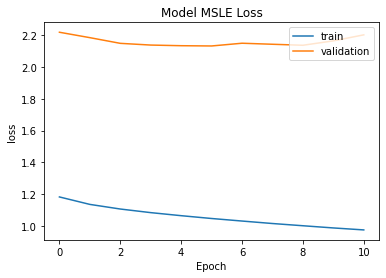

In [ ]:
## Plot for First Half of dataset WITH tweet_id
## Plot train and validation accuracy for each epoch
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0, 1]) ## Range of y-axis values
plt.legend(loc='upper right')
plt.title('Model MSLE Loss')
plt.show()

In [ ]:
## Second Half of dataset WITH tweet_id
history2 = model_cp.fit(batch_train, epochs=30, verbose=1,validation_data = batch_valid,callbacks =[early_stopping,cp_callback])

Epoch 1/30
 3156/22088 [===>..........................] - ETA: 4:46 - loss: 2.1327 - mean_squared_logarithmic_error: 2.1328 - accuracy: 0.0046
Epoch 00001: val_loss improved from inf to 2.13265, saving model to ./Saved_Models
22088/22088 [==============================] - 504s 23ms/step - loss: 1.3712 - mean_squared_logarithmic_error: 1.3711 - accuracy: 0.0066 - val_loss: 2.1327 - val_mean_squared_logarithmic_error: 2.1328 - val_accuracy: 0.0046
Epoch 2/30
 3154/22088 [===>..........................] - ETA: 4:49 - loss: 2.0806 - mean_squared_logarithmic_error: 2.0806 - accuracy: 0.0046
Epoch 00002: val_loss improved from 2.13265 to 2.08037, saving model to ./Saved_Models
22088/22088 [==============================] - 495s 22ms/step - loss: 1.1247 - mean_squared_logarithmic_error: 1.1248 - accuracy: 0.0080 - val_loss: 2.0804 - val_mean_squared_logarithmic_error: 2.0805 - val_accuracy: 0.0046
Epoch 3/30
 3154/22088 [===>..........................] - ETA: 4:41 - loss: 2.0671 - mean_square

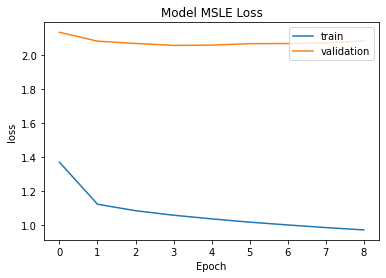

In [ ]:
## Plot for Second Half of dataset WITH tweet_id
## Plot train and validation accuracy for each epoch
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0, 1]) ## Range of y-axis values
plt.legend(loc='upper right')
plt.title('Model MSLE Loss')
plt.show()